In this notebook, we'll be using a GRU model for a time series prediction task and we will compare the performance of the GRU model against an LSTM model as well. The dataset that we will be using is the Hourly Energy Consumption dataset which can be found on [Kaggle](https://www.kaggle.com/robikscube/hourly-energy-consumption). The dataset contains power consumption data across different regions around the United States recorded on an hourly basis.

You can run the code implementation in this article on FloydHub using their GPUs on the cloud by clicking the following link and using the main.ipynb notebook.

[![Run on FloydHub](https://static.floydhub.com/button/button-small.svg)](https://floydhub.com/run?template=https://github.com/gabrielloye/https://github.com/gabrielloye/GRU_Prediction)

This will speed up the training process significantly. Alternatively, the link to the GitHub repository can be found [here]().

The goal of this implementation is to create a model that can accurately predict the energy usage in the next hour given historical usage data. We will be using both the GRU and LSTM model to train on a set of historical data and evaluate both models on an unseen test set. To do so, we’ll start with feature selection, data-preprocessing, followed by defining, training and eventually evaluating the models.

We will be using the PyTorch library to implement both types of models along with other common Python libraries used in data analytics.

In [25]:
#https://www.python-engineer.com/posts/pytorch-rnn-lstm-gru/

#https://blog.floydhub.com/gru-with-pytorch/

import os
import time
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import random
from datetime import datetime

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm_notebook
from sklearn.preprocessing import MinMaxScaler,QuantileTransformer
from sklearn.model_selection import train_test_split






### Local ###
#from data_processing import *



# Define data root directory

#data_dir = "./data/"
#print(os.listdir(data_dir))

We have a total of **12** *.csv* files containing hourly energy trend data (*'est_hourly.paruqet'* and *'pjm_hourly_est.csv'* are not used). In our next step, we will be reading these files and pre-processing these data in this order:
- Getting the time data of each individual time step and generalizing them
    - Hour of the day *i.e. 0-23*
    - Day of the week *i.e. 1-7*
    - Month *i.e. 1-12*
    - Day of the year *i.e. 1-365*
    
    
- Scale the data to values between 0 and 1
    - Algorithms tend to perform better or converge faster when features are on a relatively similar scale and/or close to normally distributed
    - Scaling preserves the shape of the original distribution and doesn't reduce the importance of outliers.
    
    
- Group the data into sequences to be used as inputs to the model and store their corresponding labels
    - The **sequence length** or **lookback period** is the number of data points in history that the model will use to make the prediction
    - The label will be the next data point in time after the last one in the input sequence
    

- The inputs and labels will then be split into training and test sets

In [26]:
#choppeddata=pd.read_csv('choppeddata_10_04_2021.csv')#.head()
choppeddata=pd.read_csv('choppeddata_10_04_2021_equalsuccessfail.csv')#.head()

print(choppeddata.shape)
runqty=int(choppeddata.shape[0]/6)
print("total runs:",runqty)
choppedheaders=[]
lookback=10 #save only the last 11 timesteps
for i in range(lookback):  
    label=str(i)
    choppedheaders.append("header"+label)

#put chopped data in np.arrays
State=np.zeros((runqty,5,lookback)) #96 runs,with 5 sets of data (x,y,z,roll,pitch) each, and each run is 11 timesteps long
Labels=np.zeros((runqty,lookback)) #96 runs, each run is 11 timesteps long
runcounter=0

for i in range(0,choppeddata.shape[0],6):
            State[runcounter][0][:]=(choppeddata[choppedheaders[:]].iloc[i]).tolist()
            State[runcounter][1][:]=(choppeddata[choppedheaders[:]].iloc[i+1]).tolist()
            State[runcounter][2][:]=(choppeddata[choppedheaders[:]].iloc[i+2]).tolist()
            State[runcounter][3][:]=(choppeddata[choppedheaders[:]].iloc[i+3]).tolist()
            State[runcounter][4][:]=(choppeddata[choppedheaders[:]].iloc[i+4]).tolist()
            Labels[runcounter][:]=(choppeddata[choppedheaders[:]].iloc[i+5]).tolist()  #labels   
            runcounter+=1
#print(State[0])
#print(Labels)
#print(Labels[:,9]) #just getting finals labels

(1440, 10)
total runs: 240


In [33]:
#X= range(0,575,6)
#y= range(0,575,6)

X=State
y=Labels[:,lookback-1]
print(X.shape)

y=y.reshape(runqty,1)

random_seed=int(time.time())
#print(int(time.time()))
train_x, test_x, train_y,test_y = train_test_split(X, y, test_size=.3, #0.33, 
                                                   random_state=random_seed)
print("Train")
print(train_x[0])
print(train_y[0])
print("Train set Y size", train_y.size)
print("Test")
print(test_x[0])
print(test_y[0])
print("Test set Y size", test_y.size)

(240, 5, 10)
Train
[[0.32337989 0.29366051 0.30611687 0.28249696 0.3033929  0.27148917
  0.26921812 0.27030818 0.3029921  0.2582378 ]
 [0.413702   0.40371303 0.41205799 0.39698196 0.39805865 0.38818895
  0.39967939 0.39496    0.40166448 0.40594263]
 [0.91733656 0.92878061 0.91262347 0.93642075 0.90958736 0.91842746
  0.931326   0.91832239 0.9175356  0.86251146]
 [0.5836381  0.59202626 0.58286799 0.59825609 0.58787285 0.60386767
  0.59341128 0.59809911 0.59239054 0.58877876]
 [0.29295783 0.27121509 0.28602254 0.2662374  0.27418573 0.25606732
  0.25360484 0.25400682 0.27119794 0.24656641]]
[1.]
Train set Y size 168
Test
[[0.2469882  0.33444644 0.33334421 0.46198377 0.40827571 0.35897836
  0.35044899 0.34558518 0.34404555 0.32776489]
 [0.40892476 0.45313222 0.43188842 0.4425597  0.43575128 0.44167376
  0.43713358 0.43455415 0.40974931 0.43629187]
 [0.74955812 0.93008054 0.92470881 0.92670213 0.92084688 0.92199093
  0.91233924 0.91440175 0.9170262  0.86986301]
 [0.59588585 0.57721795 0.579

We have a total of 980,185 sequences of training data

To improve the speed of our training, we can process the data in batches so that the model does not need to update its weights as frequently. The Torch *Dataset* and *DataLoader* classes are useful for splitting our data into batches and shuffling them.

In [34]:
batch_size = 4
#a batch size of 64, i.e. each element in the dataloader iterable will return a batch of 64 features and labels.

train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)

test_data   = TensorDataset( torch.from_numpy( test_x ), torch.from_numpy( test_y ) )
test_loader = DataLoader( test_data, shuffle = True, batch_size = batch_size, drop_last = True )


In [35]:
print(train_loader)

We can also check if we have any GPUs to speed up our training time by many folds. If you’re using FloydHub with GPU to run this code, the training time will be significantly reduced.

In [36]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    
print(device)


def get_torch_device( v=0 ):
    # torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
    is_cuda = torch.cuda.is_available()
    # If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
    if is_cuda:
        device = torch.device("cuda")
        if v:  print( "CUDA Available!" )
    else:
        device = torch.device("cpu")
        if v:  print( "NO CUDA" )
    return device

cpu


In [37]:
class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(GRUNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        
    def forward(self, x, h):
        out, h = self.gru(x, h)
        out = self.fc(self.relu(out[:,-1]))
        return out, h
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        return hidden
def train(train_loader, learn_rate, hidden_dim=128, EPOCHS=400, model_type="GRU"):
    #got  109 / 180 on training set, 29 / 60 on test set from 128 hidden dim, 50 epoch, batch size of 4, lr =0.001
    #Got training data= 146 / 180, success vs test data= 38 / 60 with same as above but 100 epoch
    #Got training data= 172 / 180, success vs test data= 46 / 60 with same as above but 200 epoch
    #Got training data= 165 / 180, success vs test data= 52 / 60 with same as above but 200 epoch
    
    losslist=[]
    # Setting common hyperparameters
    input_dim = next(iter(train_loader))[0].shape[2]  #  = 11
    #print(input_dim)
    #print("input_dim",input_dim)
    output_dim = 1
    n_layers = 2
    # Instantiating the models
    if model_type == "GRU":
        model = GRUNet(input_dim, hidden_dim, output_dim, n_layers)
    else:
        model = LSTMNet(input_dim, hidden_dim, output_dim, n_layers)
    model.to(device)
    
    # Defining loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)
    
    model.train()
    print("Starting Training of {} model".format(model_type))
    epoch_times = []
    # Start training loop
    for epoch in range(1,EPOCHS+1):
        start_time = time.clock()
        h = model.init_hidden(batch_size)
        avg_loss = 0.
        counter = 0
        for x, label in train_loader:
            #print("x",x)
            #print("label",label)
            counter += 1
            if model_type == "GRU":
                h = h.data
            else:
                h = tuple([e.data for e in h])
            model.zero_grad()
            
            out, h = model(x.to(device).float(), h)
            #print("out",out)
            loss = criterion(out, label.to(device).float())
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()
            
            if counter%20000 == 0:
                print("Epoch {}......Step: {}/{}....... Average Loss for Epoch: {}".format(epoch, counter, len(train_loader), avg_loss/counter))
        current_time = time.clock()
        if epoch%40 == 0:
            print("Epoch {}/{} Done, Total Loss: {}   Time Elapsed: {} seconds".format(epoch, EPOCHS, avg_loss/len(train_loader),str(current_time-start_time)))
        
            #print("Total".format())
        losslist.append(avg_loss/len(train_loader))
        epoch_times.append(current_time-start_time)
    print("Total Training Time: {} seconds".format(str(sum(epoch_times))))
    plt.plot(losslist)
    plt.title("Loss")
    plt.show()
    return model

def evaluate(model, test_x, test_y):
    model.eval()
    outputs = []
    targets = []
    start_time = time.clock()
    #for i in test_x.keys():
    for i in range( len( test_x ) ):    
        inp = torch.from_numpy(np.array(test_x[i])) # should be 5x1
        labs = torch.from_numpy(np.array(test_y[i])) #should be 1x1
        h = model.init_hidden(inp.shape[0])
        #print("inp",inp)
        #print("labs",labs)
        #print("h",h)
        out, h = model(inp.to(device).float(), h)
        #outputs.append(label_scalers[i].inverse_transform(out.cpu().detach().numpy()).reshape(-1))
        #targets.append(label_scalers[i].inverse_transform(labs.numpy()).reshape(-1))
        outputs.append( out.cpu().detach().numpy().reshape(-1) )
        targets.append( labs.numpy().reshape(-1) )
        
    print("Evaluation Time: {}".format(str(time.clock()-start_time)))
    sMAPE = 0
    for i in range(len(outputs)):
        sMAPE += np.mean(abs(outputs[i]-targets[i])/(targets[i]+outputs[i])/2)/len(outputs)
    print("sMAPE: {}%".format(sMAPE*100))
    return outputs, targets, sMAPE
                               
def evaluate2(model, test_x, test_y):
    model.eval()
    outputs = []
    targets = []
    start_time = time.clock()
    #for i in test_x.keys():
    #for i in range( len( test_x ) ):    
    inp = torch.from_numpy(np.array(test_x)) # should be 5x1
    labs = torch.from_numpy(np.array(test_y)) #should be 1x1
    h = model.init_hidden(inp.shape[0])
    #print("inp",inp)
    #print("labs",labs)
    #print("h",h)
    out, h = model(inp.to(device).float(), h)
    #outputs.append(label_scalers[i].inverse_transform(out.cpu().detach().numpy()).reshape(-1))
    #targets.append(label_scalers[i].inverse_transform(labs.numpy()).reshape(-1))
    outputs.append( out.cpu().detach().numpy().reshape(-1) )
    targets.append( labs.numpy().reshape(-1) )
        
    print("Evaluation Time: {}".format(str(time.clock()-start_time)))
    sMAPE = 0
    for i in range(len(outputs)):
        sMAPE += np.mean(abs(outputs[i]-targets[i])/(targets[i]+outputs[i])/2)/len(outputs)
    print("sMAPE: {}%".format(sMAPE*100))
    return outputs, targets, sMAPE                               

def evaluatefull(model, train_x, train_y, test_x, test_y):

    m = nn.ReLU()
    #m = nn.Sigmoid()
    #output = m(input)
    print("Vs Training Set")
    gru_outputs, targets, gru_sMAPE = evaluate2(gru_model, train_x, train_y)
    #print(test_y)
    #print(gru_outputs)
    #print(gru_outputs[0][5])


    testy=test_y.reshape(-1)
    trainy=train_y.reshape(-1)


    print("Train size:",trainy.size)
    print(gru_outputs[0][4])
    train_successcounter=0
    for i in range(int(trainy.size)):
        #print(testy[i],gru_outputs[0][i],m(torch.tensor(gru_outputs[0][i])))
        #print(train[i],gru_outputs[0][i],m(torch.tensor(gru_outputs[0][i])))


        #print(trainy[i],gru_outputs[0][i], m(torch.tensor(gru_outputs[0][i])))


        if abs(trainy[i]-gru_outputs[0][i])<0.2 :
            train_successcounter+=1
        #print(testy[i])
        #print
        #output = m(input)



    test_successcounter=0
    print("Vs Test Set")
    gru_outputs, targets, gru_sMAPE = evaluate2(gru_model, test_x, test_y)
    print("test size: ",testy.size)

    for i in range(int(testy.size)):


        #, m(torch.tensor(gru_outputs[0][i])))


        if abs(testy[i]-gru_outputs[0][i])<0.2 :
            test_successcounter+=1
            #print(testy[i],gru_outputs[0][i], "OK" )
        #else:
            #print(testy[i],gru_outputs[0][i], "X" )
            #print(testy[i])
        #print
        #output = m(input)
    print("")
    print("success vs training data=" ,train_successcounter,"/",trainy.size)    
    print("success vs test data=" ,test_successcounter,"/",testy.size)


Starting Training of GRU model
Epoch 40/350 Done, Total Loss: 0.12818678623686233   Time Elapsed: 1.7229349999997794 seconds
Epoch 80/350 Done, Total Loss: 0.07007921867937382   Time Elapsed: 1.7241859999999178 seconds
Epoch 120/350 Done, Total Loss: 0.03885371871348027   Time Elapsed: 1.7299389999998311 seconds
Epoch 160/350 Done, Total Loss: 0.029907822211195405   Time Elapsed: 1.572360000000117 seconds
Epoch 200/350 Done, Total Loss: 0.020347999533571835   Time Elapsed: 1.7253599999999096 seconds
Epoch 240/350 Done, Total Loss: 0.023382882591769367   Time Elapsed: 1.5708880000001955 seconds
Epoch 280/350 Done, Total Loss: 0.01672640793341478   Time Elapsed: 1.623471999999765 seconds
Epoch 320/350 Done, Total Loss: 0.009226167935204492   Time Elapsed: 1.7170759999999063 seconds
Total Training Time: 584.6232630000072 seconds


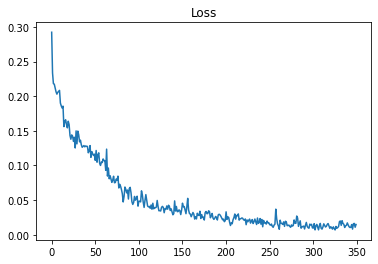

Vs Training Set
Evaluation Time: 0.06392800000003263
sMAPE: -7.105205678158007%
Train size: 168
-0.0042839646
Vs Test Set
Evaluation Time: 0.04836699999987104
sMAPE: 14.542788876514267%
test size:  72

success vs training data= 162 / 168
success vs test data= 50 / 72


In [38]:
lr = 0.001
gru_model = train(train_loader, lr , hidden_dim=128, EPOCHS=350, model_type="GRU")

evaluatefull(gru_model, train_x, train_y, test_x, test_y)

#got  109 / 180 on training set, 29 / 60 on test set from 128 hidden dim, 50 epoch, batch size of 4, lr =0.001,test_size=.25
#Got training data= 146 / 180, success vs test data= 38 / 60 with same as above but 100 epoch
#Got training data= 172 / 180, success vs test data= 46 / 60 with same as above but 200 epoch
#Got training data= 165 / 180, success vs test data= 52 / 60(86%) with same as above but 400 epoch-BEST RESULT!
#Got training data= 179 / 180, success vs test data= 50 / 60 with same as above but 400 epoch
#Got training data= 165 / 180, success vs test data= 52 / 60 with same as above but 400 epoch
#test data= 42 / 60 , 45/60

#got  154/160 on training set, 62 / 80(.77) on test set from 128 hidden dim, 300 epoch, batch size of 4, lr =0.001,test_size=.33
#got  159/160 on training set, 60 / 80(.75) on test set from 128 hidden dim, 400 epoch, batch size of 4, lr =0.001,test_size=.33
#got  136/160 on training set, 55 / 80  on test set from 128 hidden dim, 500 epoch, batch size of 4, lr =0.001,test_size=.33

#Got training data=  178 / 180, success vs test data= 46 / 60 with same as above but- 400 epoch, batch size =2
#Got training data=  178 / 180, success vs test data= 47 / 60 with same as above but- 400 epoch, batch size =8
#Got training data=  179 / 180, success vs test data= 48 / 60 with same as above but- 600 epoch, batch size =8
#Got training data=  165 / 180, success vs test data= 44 / 60 with same as above but- 600 epoch, batch size =8, lr=0.0005
#Got training data=  179 / 180, success vs test data= 45 / 60 with same as above but- 800 epoch, batch size =8, lr=0.0005
#Got training data=  177 / 180, success vs test data= 39 / 60 with same as above but- 800 epoch, batch size =4, lr=0.0005
#Got training data= 173 / 180, success vs test data= 42 / 60 with same as above but 500 epoch
#Got training data= 178 / 180, success vs test data= 44 / 60 with same as above but 800 epoch


#The target size means the label size!

In [ ]:
model=gru_model
i=1
inp = torch.from_numpy(np.array(test_x))
labs = torch.from_numpy(np.array(test_y))
#h = model.init_hidden(inp.shape[0])
h = model.init_hidden(inp.shape[0])
#print("inp",inp)

#print("INP SHAPE",inp.shape)
#print("INP SHAPE[0]",inp.shape[0])
#print("labs",labs)
#print("h",h)
#print("h.shape",h.shape)
#print(inp.to(device).float())
#print(inp.to(device).float().shape)
print(inp.to(device).float().shape)

out, h = model(inp.to(device).float(), h)
#print(out)

In [ ]:
i=0    
print(testy[i])
print(gru_outputs[0][i])
print(np.abs(testy[i]-gru_outputs[0][i]))
print(np.abs(testy[i]-gru_outputs[0][i])<0.2)

print(trainy[i],gru_outputs[0][i] )

"""
if np.abs(testy[i]-gru_outputs[0][i])<0.2 :
   
    print(trainy[i],gru_outputs[0][i], "OK" )
else:
    print(trainy[i],gru_outputs[0][i], "X" )
    

if 0.0-0.91831344>0.2 :
    print("ok")
"""

In [ ]:
#print(test_y.reshape(-1))
